# Train/Test the True Relationship Model

This notebook is design to predict DG relationships on the entity level. Here we are taking the input from the Bi-LSTM model, prior probability notebook and the summary statistics notebook and combinging it into a single dataset. From there we train a Ridge LR model and an elastic net LR model to make the final prediction.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from scipy.stats import fisher_exact
from scipy.special import logit
import scipy
from sqlalchemy import and_
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
candidate_df = pd.read_csv("data/disease_gene_summary_stats_lstm_full_trained.csv")
prior_df = pd.read_csv("data/observation-prior.csv")

In [3]:
candidate_df["lstm_avg_marginal"] = pd.np.log(candidate_df["lstm_avg_marginal"])
candidate_df.head(10)

,disease_id,gene_id,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,lstm_marginal_0_quantile,lstm_marginal_20_quantile,lstm_marginal_40_quantile,lstm_marginal_60_quantile,lstm_marginal_80_quantile,disease_name,gene_name,lstm_avg_marginal
0,DOID:12849,3569,2.072881e-04,0.617773,62.795531,-0.001252,1,0.078761,0.085288,0.102422,0.219338,0.776196,autistic disorder,IL6,-1.048668
1,DOID:3070,567,3.358850e-09,0.192395,86.200979,-0.025416,-1,0.080163,0.080986,0.081366,0.081806,0.082120,malignant glioma,B2M,-2.506294
2,DOID:1324,6647,-0.000000e+00,0.142479,194.551269,-0.044854,-1,0.070739,0.080279,0.081723,0.082573,0.083470,lung cancer,SOD1,-2.505170
3,DOID:3121,2353,1.315072e+00,2.319352,2.589809,-0.000705,-1,0.081434,0.081759,0.082209,0.082515,0.082632,gallbladder cancer,FOS,-2.498415
4,DOID:10652,5520,1.116009e+00,2.601331,1.549830,-0.022814,-1,0.081397,0.081565,0.081628,0.082331,0.083186,Alzheimer's disease,PPP2R2A,-2.497457
5,DOID:5041,319100,7.489680e+00,24.599058,0.301847,0.020276,-1,0.081621,0.082122,0.082662,0.083329,0.110226,esophageal cancer,TAAR6,-2.214222
6,DOID:2531,6400,6.776874e-02,0.674023,6.909290,-0.102290,-1,0.082111,0.082442,0.082795,0.083040,0.083093,hematologic cancer,SEL1L,-2.489707
7,DOID:1936,22846,4.202512e-01,1.528825,1.291256,-0.020213,-1,0.081269,0.081269,0.081269,0.081269,0.081269,atherosclerosis,VASH1,-2.509996
8,DOID:2377,10804,1.581787e+00,4.934903,0.613036,-0.018946,-1,0.082673,0.082896,0.083119,0.083342,0.083565,multiple sclerosis,GJB6,-2.486143
9,DOID:14227,83844,3.600000e+01,4841.654246,0.009900,0.538260,1,0.080865,0.082741,0.083437,0.084086,0.093096,azoospermia,USP26,-1.867627


In [4]:
prior_df["logit_prior_perm"] = logit(prior_df["prior_perm"])
prior_df.head(10)

,disease_id,gene_id,disease_associates,gene_associates,prior_perm,prior_perm_stderr,logit_prior_perm
0,DOID:2531,7124,550,47,0.870898,0.000558,1.908922
1,DOID:2531,7157,550,46,0.867094,0.000565,1.875505
2,DOID:2531,5743,550,40,0.830758,0.000624,1.591009
3,DOID:2531,3569,550,39,0.823473,0.000634,1.540057
4,DOID:2531,4318,550,37,0.809203,0.000654,1.444840
5,DOID:2531,3586,550,35,0.793287,0.000674,1.344854
6,DOID:2531,7422,550,34,0.783978,0.000685,1.289001
7,DOID:2531,7040,550,33,0.777711,0.000692,1.252377
8,DOID:2531,3553,550,31,0.758141,0.000712,1.142514
9,DOID:2531,213,550,30,0.747171,0.000723,1.083581


# Set up the Training and Testing Set

In [5]:
train_df = pd.read_csv("stratified_data/train_set.csv")
dev_df = pd.read_csv("stratified_data/dev_set.csv")
test_df = pd.read_csv("stratified_data/test_set.csv")

In [6]:
# Gather the summary stats for each candidate
training_set = pd.merge(candidate_df, train_df.query("pubmed==1")[["disease_id", "gene_id", "hetnet"]], 
                        how='inner', on=["disease_id", "gene_id"])
dev_set = pd.merge(candidate_df, dev_df.query("pubmed==1")[["disease_id", "gene_id", "hetnet"]],
                   how='inner', on=["disease_id", "gene_id"])
test_set = pd.merge(candidate_df, test_df.query("pubmed==1")[["disease_id", "gene_id", "hetnet"]], 
                    how='inner', on=["disease_id", "gene_id"])


# Drop the values that aren't found in pubmed. 
training_set = training_set.drop("hetnet_labels", axis=1)
dev_set = dev_set.drop("hetnet_labels", axis=1)
test_set = test_set.drop("hetnet_labels", axis=1)

training_set = training_set.dropna()
dev_set = dev_set.dropna()
test_set = test_set.dropna()

# Add the prior prob to the different sets 
training_set = pd.merge(training_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]])
dev_set = pd.merge(dev_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]])
test_set = pd.merge(test_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]])

In [7]:
non_features = [
    "hetnet", "disease_id", "gene_id", 
    "gene_name", "disease_name",
    "pubmed", "lstm_marginal_0_quantile", 
    "lstm_marginal_20_quantile","lstm_marginal_40_quantile",
    "lstm_marginal_60_quantile", "lstm_marginal_80_quantile"
]

X = training_set[[col for col in training_set.columns if col not in non_features]]
Y = training_set["hetnet"]

X_dev = dev_set[[col for col in dev_set.columns if col not in non_features]]
Y_dev = dev_set["hetnet"]

X_test = test_set[[col for col in test_set.columns if col not in non_features]]
Y_test = test_set["hetnet"]

In [8]:
print(Y.value_counts())
print()
print(Y_dev.value_counts())
print()
print(Y_test.value_counts())
print()

-1    61979
 1     6634
Name: hetnet, dtype: int64

-1    17715
 1     1896
Name: hetnet, dtype: int64

-1    8866
 1     948
Name: hetnet, dtype: int64



In [9]:
train_Y = Y.append(Y_dev)
train_X = X.append(X_dev)

# Train the Machine Learning Algorithms

Here we use gridsearch to optimize both models using 10 fold cross validation. After exhausting the list of parameters, the best model is chosen and analyzed in the next chunk. 

In [10]:
n_iter = 100
final_models = []

lr = LogisticRegression()
lr_grid = {'C':np.linspace(1, 100, num=100)}

no_lstm_normalizer = StandardScaler()
lstm_normalizer = StandardScaler()

In [11]:
%%time

# Train on data without LSTM input
lstm_features = [
    "lstm_avg_marginal"
]

tempX = train_X[[col for col in X.columns if col not in lstm_features]]

transformed_tempX = no_lstm_normalizer.fit_transform(tempX)
transformed_X = lstm_normalizer.fit_transform(train_X)

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 22.1 ms


In [12]:
%%time

final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3, scoring='roc_auc', return_train_score=True)
final_model.fit(transformed_tempX, train_Y)
final_models.append(final_model)

CPU times: user 7.91 s, sys: 407 ms, total: 8.32 s
Wall time: 1min 44s


In [13]:
%%time

# Train on data with LSTM input
final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3, scoring='roc_auc', return_train_score=True)
final_model.fit(transformed_X, train_Y)
final_models.append(final_model)

CPU times: user 8.93 s, sys: 376 ms, total: 9.31 s
Wall time: 1min 47s


## Parameter Optimization

In [14]:
no_lstm_result = pd.DataFrame(final_models[0].cv_results_)
lstm_result = pd.DataFrame(final_models[1].cv_results_)

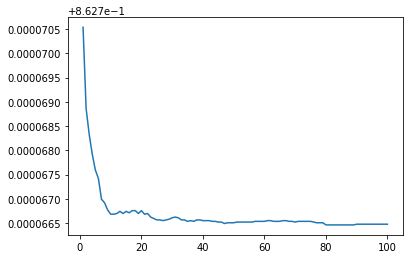

In [15]:
# No LSTM
plt.plot(no_lstm_result['param_C'], no_lstm_result['mean_test_score'])

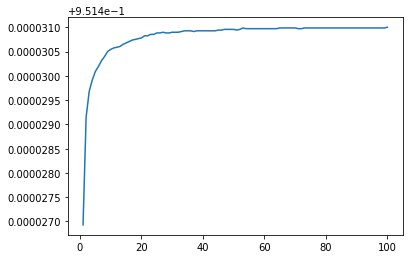

In [16]:
# LSTM
plt.plot(lstm_result['param_C'], lstm_result['mean_test_score'])

## LR Weights

In [17]:
list(zip(final_models[0].best_estimator_.coef_[0], [col for col in training_set.columns if col not in lstm_features+non_features]))

[(0.77037646532577841, 'nlog10_p_value'),
 (0.44352948290791988, 'co_odds_ratio'),
 (0.014987454864915851, 'co_expected_sen_count'),
 (0.27086764307199096, 'delta_lower_ci'),
 (1.0841512480985638, 'logit_prior_perm')]

In [18]:
list(zip(final_models[1].best_estimator_.coef_[0], [col for col in training_set.columns if col not in non_features]))

[(0.76771270652035117, 'nlog10_p_value'),
 (0.13519976034867839, 'co_odds_ratio'),
 (0.017995278979579137, 'co_expected_sen_count'),
 (0.2253873109337495, 'delta_lower_ci'),
 (1.7673311354289376, 'lstm_avg_marginal'),
 (0.61145226405450492, 'logit_prior_perm')]

# AUROCS

(0.5, 1)

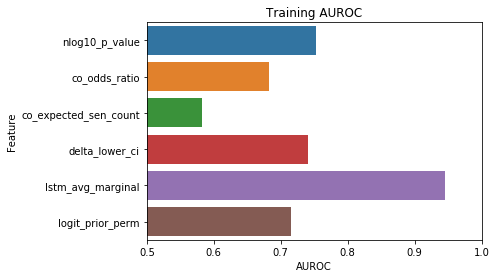

In [19]:
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(train_Y, train_X[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df)
plt.title("Training AUROC")
plt.xlim([0.5,1])

(0.5, 1)

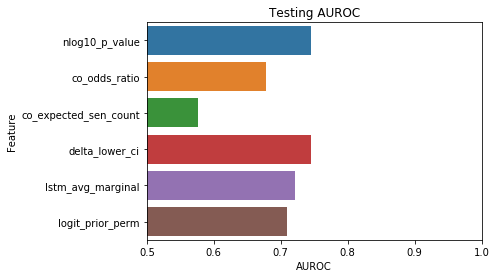

In [20]:
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(Y_test, X_test[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df)
plt.title("Testing AUROC")
plt.xlim([0.5,1])

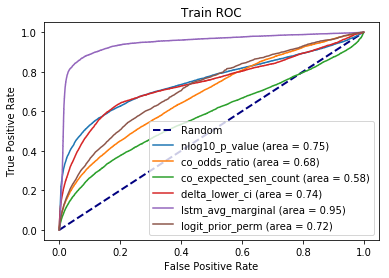

In [21]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in train_X.columns:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(train_Y, train_X[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

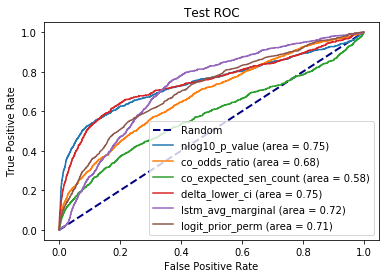

In [22]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in X.columns:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(Y_test, X_test[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")

# Corerlation Matrix

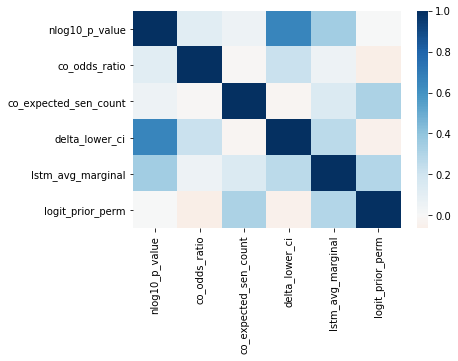

In [23]:
feature_corr_mat = train_X.corr()
sns.heatmap(feature_corr_mat, cmap="RdBu", center=0)

# ML Performance

In [24]:
transformed_tempX_test = no_lstm_normalizer.transform(X_test[[col for col in X.columns if col not in lstm_features]])
transformed_X_test = lstm_normalizer.transform(X_test)

In [25]:
colors = ["green","red"]
labels = ["LR_NO_LSTM","LR_LSTM"]

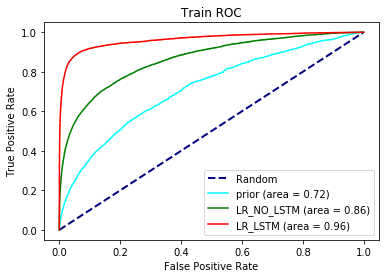

In [26]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(train_Y, train_X["logit_prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan', label="{} (area = {:0.2f})".format("prior", model_auc))

fpr, tpr, thresholds= roc_curve(train_Y, final_models[0].predict_proba(transformed_tempX)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[0], label="{} (area = {:0.2f})".format(labels[0], model_auc))

fpr, tpr, thresholds= roc_curve(train_Y, final_models[1].predict_proba(transformed_X)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[1], label="{} (area = {:0.2f})".format(labels[1], model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

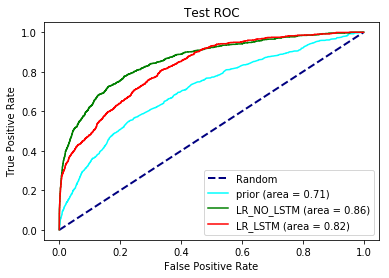

In [27]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(Y_test, X_test["logit_prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan', label="{} (area = {:0.2f})".format("prior", model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[0], label="{} (area = {:0.2f})".format(labels[0], model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[1], label="{} (area = {:0.2f})".format(labels[1], model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")

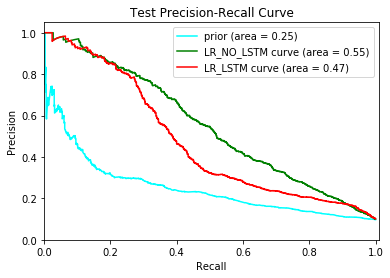

In [28]:
plt.figure()

# Plot the p_values log transformed
precision, recall, _= precision_recall_curve(Y_test, X_test["logit_prior_perm"])
model_precision = average_precision_score(Y_test, X_test["logit_prior_perm"])
plt.plot(recall, precision, color='cyan', label="{} (area = {:0.2f})".format("prior", model_precision))

precision, recall, _ = precision_recall_curve(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
model_precision = average_precision_score(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
plt.plot(recall, precision, color=colors[0], label="{} curve (area = {:0.2f})".format(labels[0], model_precision))
  
precision, recall, _ = precision_recall_curve(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
model_precision = average_precision_score(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
plt.plot(recall, precision, color=colors[1], label="{} curve (area = {:0.2f})".format(labels[1], model_precision))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Test Precision-Recall Curve')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="upper right")

## Save Final Result in DF

In [ ]:
predictions = final_models[1].predict_proba(train_X.append(X_test))
predictions_df = training_set.append(dev_set).append(test_set)[[
    "disease_id","disease_name", 
    "gene_id", "gene_name", 'hetnet']]
predictions_df["predictions"] = predictions[:,1]

In [ ]:
predictions_df.to_csv("data/vanilla_lstm/final_model_predictions.csv", index=False)